<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
from __future__ import print_function

%matplotlib inline

import os
import numpy
import matplotlib.pyplot as plt
import matplotlib.animation

from IPython.display import HTML
from clawpack import pyclaw
from clawpack import riemann

# Finite Volume Methods for Nonlinear Scalar Conservation Laws

As we saw previously, if we have a nonlinear conservation law that it be considered in this form or a form of nonuniqueness will result apart from the use of the weak form.  This extends to the numerical case as well and is critical to come to proper approximation of the weak solutions to the conservation law.

## Godunov's Method

From our original formulation of Godunov's method we obtained the numerical flux by evaluating the solution along the grid cell edge in time
$$
    F^n_{i-1/2} = f(Q_{i-1/2}).
$$
For nonlinear scalar problems there are 5 different configurations that may occur:
1. Shock traveling to the left
1. Rarefaction traveling fully to the left
1. A centered rarefaction
1. Rarefaction traveling fully to the right
1. Shock traveling to the right

In all but case 3 we know what value to pick to evaluate the flux function, i.e. $Q_{i-1}$ for case 1 and 2 and $Q_i$ for case 4 and 5.  For case 2 however it is no longer clear what value $Q$ to use.

Suppose that $f''(q) > 0$ everywhere such that if $Q_{i-1} < Q_i$ leads to a rarefaction.  If $Q_{i-1} < q_s < Q_i$ such that $q_s$ is the unique value where $f'(q_s) = 0$.  The value $q_s$ is often called a **stagnation point** as it propagates with speed 0.  It can also be called a **sonic point** as in gas dynamics (and shallow water) the speeds can by 0 only if the fluid speed $|u|$ and the sound speed (or gravity wave speed) equal.

With this being said we can generalize the Godunov flux function as
$$
    F^n_{i-1/2} = \left \{ \begin{aligned}
        &f(Q_{i-1}) & & \text{if } Q_{i-1} > q_s &\text{and } & s > 0 \\
        &f(Q_{i}) & & \text{if } Q_{i} < q_s &\text{and } & s < 0 \\
        &f(q_s) & & \text{if } Q_{i-1} < q_s < Q_i & &
    \end{aligned} \right .
$$
where $s$ is the Rankine-Hugoniot derived shock speed.

## Fluctuations, Waves, and Speeds

We still want to express Godunov's method in terms of our waves and fluctuations.  Recall our standard, first-order scheme
$$
    Q^{n+1}_i = Q^n_i - \frac{\Delta t}{\Delta x} (\mathcal{A}^+ \Delta Q_{i-1/2} + \mathcal{A}^- \Delta Q_{i+1/2} )
$$
where we define $\mathcal{A}^\pm \Delta Q_{i-1/2}$ as
$$\begin{aligned}
    &\mathcal{A}^+ \Delta Q_{i-1/2} = f(Q_i) - f(\widehat{Q}_{i-1/2}) \\
    &\mathcal{A}^- \Delta Q_{i-1/2} = f(\widehat{Q}_{i-1/2}) - f(Q_{i-1})
\end{aligned}$$

For the waves $\mathcal{W}_{i-1/2}$ and speeds $s_{i-1/2}$ that come into the higher-order correction terms we naturally have
$$
    \mathcal{W}_{i-1/2} = Q_i - Q_{i-1}
$$
and
$$
    s_{i-1/2} = \left \{ \begin{aligned}
        &\frac{f(Q_i) - f(Q_{i-1})}{Q_i - Q_{i-1}} & & \text{if } Q_{i-1} \neq Q_i \\
        &f'(Q_i) & & \text{if } Q_{i-1} = Q_i
    \end{aligned} \right .
$$

## Transonic Rarefactions and Entropy Fixes

Up until now we have only described a method that satisfies the Rankine-Hugoniot conditions but does not consider our previous case 3, a transonic/centered rarefaction.  If we were not to treat this case specially we would be violating our entropy conditions.

In order to handle this case we must apply what is mostly commonly termed an **entropy fix**.  An entropy fix aims to modify $\mathcal{A}^\pm \Delta Q_{i-1/2}$ such that it handles the transonic case and maintains an entropy satisfying solution.

In [2]:
def true_solution(x, t):
    if t > 0:
        t_vec = t * numpy.ones(x.shape)
        return (x < 0) * -numpy.ones(x.shape) + \
           (-t_vec < x) * (x <= 0) * (x / t_vec + 1) + \
           (0 <= x) * (x <= 2*t_vec) * x / t_vec + \
           (2 * t_vec <= x) * 2.0 * numpy.ones(x.shape)
    else:
        return (x < 0) * -numpy.ones(x.shape) + \
           (0.0 <= x) * 2.0 * numpy.ones(x.shape)

def burgers_animation(order=2, efix=True):
   
    solver = pyclaw.ClawSolver1D(riemann.burgers_1D_py.burgers_1D)
    solver.kernel_language = "Python"
    
    solver.limiters = pyclaw.limiters.tvd.MC
    solver.bc_lower[0] = pyclaw.BC.extrap
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.order = order

    x = pyclaw.Dimension(-3.0, 3.0, 50, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    state = pyclaw.State(domain, num_eqn)
    xc = domain.grid.x.centers
    state.q[0,:] = (xc < 0) * -numpy.ones(xc.shape) + 2.0 * (xc >= 0) * numpy.ones(xc.shape)
    state.problem_data['efix'] = efix

    claw = pyclaw.Controller()
    claw.tfinal = 1.0
    claw.num_output_times   = 10
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver

    claw.keep_copy = True
    claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-1.5, 2.5))
    axes.set_title("Burgers Equation")
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-1.5, 2.5))
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'bo-')
        true_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'k-')
        return (computed_line, true_line)
    
    computed_line, true_line = init()
    
    def fplot(n):
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        true_line.set_data([x,], [true_solution(x, claw.frames[n].t)])
        return (computed_line, true_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=init, repeat=False)

In [3]:
HTML(burgers_animation(order=2, efix=True).to_jshtml())

2025-10-16 13:36:30,170 INFO CLAW: Solution 0 computed for time t=0.000000
2025-10-16 13:36:30,172 INFO CLAW: Solution 1 computed for time t=0.100000
2025-10-16 13:36:30,174 INFO CLAW: Solution 2 computed for time t=0.200000
2025-10-16 13:36:30,176 INFO CLAW: Solution 3 computed for time t=0.300000
2025-10-16 13:36:30,178 INFO CLAW: Solution 4 computed for time t=0.400000
2025-10-16 13:36:30,180 INFO CLAW: Solution 5 computed for time t=0.500000
2025-10-16 13:36:30,181 INFO CLAW: Solution 6 computed for time t=0.600000
2025-10-16 13:36:30,183 INFO CLAW: Solution 7 computed for time t=0.700000
2025-10-16 13:36:30,185 INFO CLAW: Solution 8 computed for time t=0.800000
2025-10-16 13:36:30,187 INFO CLAW: Solution 9 computed for time t=0.900000
2025-10-16 13:36:30,189 INFO CLAW: Solution 10 computed for time t=1.000000
2025-10-16 13:36:30,232 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:30,293 INFO CLAW: No LaTeX-compatible 

The practical application of an entropy fix usually consists of an indicator that the original solution may not be sufficient.  In other words in the case that there may exist a transonic rarefaction.  For scalar conservation laws this will occur when
$$
    f'(Q_{i-1}) < 0 < f'(Q_i)
$$
in which case we redefine $\mathcal{A}^\pm \Delta Q_{i-1/2}$ with
$$\begin{aligned}
    &\mathcal{A}^+ \Delta Q_{i-1/2} = f(Q_i) - f(q_s) \\
    &\mathcal{A}^- \Delta Q_{i-1/2} = f(q_s) - f(Q_i)
\end{aligned}$$

## Numerical Viscosity

It is evident that method mentioned above is not completely incorrect. How can this be the case when we know that the proper entropy satisfying solution should not be represented at all.  Instead we see a solution that partially does have the correct rarefaction structure.  What could be going on?

The fact that we are in reality getting a "pretty good" solution is that in reality the dominant error is providing a form of numerical viscosity that acts to create something like a physical viscosity that would match somewhat we want to approximate.  This suggests that, similar to finite-difference analysis, that what we really require is a form of regularization with some diffusion to obtain true solutions.

In the case of finite volume methods we can consider a numerical flux function
$$
    F_{i-1/2} = \frac{1}{2} [ f(Q_{i-1}) + f(Q_i) - |s_{i-1/2}| (Q_i - Q_{i-1})]
$$
that we know works as an unstable flux plus a diffusive like term.

## Lax-Friedrichs and Local Lax-Friedrichs Methods

A class of methods use a similar flux definition that was just mentioned previously.  The flux function is
$$
    F_{i-1/2} = \frac{1}{2} [f(Q_{i-1}) + f(Q_i) - a (Q_i - Q_{i-1})].
$$

As we have seen from finite difference and method of lines type analysis, this method has a numerical viscosity of
$$
    a = \frac{\Delta x}{\Delta t}
$$
with a fixed magnitude that at a sonic point will not vanish.  We can similarly define a local version of this that only applies the significant numerical viscosity at sonic points.  This can be defined as
$$
    F_{i-1/2} = \frac{1}{2} [f(Q_{i-1}) + f(Q_i) - a_{i-1/2} (Q_i - Q_{i-1})]
$$
where
$$
    a_{i-1/2} = \max(|f'(Q_{i-1}|, |f'(Q_i)|).
$$
This method is also called **Rusanov's Method**.

Another related method is **Murman's method** which uses
$$
    a_{i-1/2} = \left |\frac{f(Q_i) - f(Q_{i-1})}{Q_i - Q_{i-1}} \right|
$$

## Engquist-Osher method

We have constructed a method so far that always assumes a shock unless otherwise determined.  What if we chose the opposite and assume that everything is a shock instead?  This is known as the **Engquist-Osher method** and is accomplished by defining
$$\begin{aligned}
    \mathcal{A}^+ \Delta Q_{i-1/2} &= \int^{Q_i}_{Q_{i-1}} (f'(q))^+ dq \\
    \mathcal{A}^- \Delta Q_{i-1/2} &= \int^{Q_i}_{Q_{i-1}} (f'(q))^- dq
\end{aligned}$$

These are all implementable in our wave-propagation methodology where
$$\begin{aligned}
    \mathcal{A}^- \Delta Q_{i-1/2} &= \frac{1}{2} [f(Q_i) - f(Q_{i-1} - a_{i-1/2} (Q_i - Q_{i-1})] \\
    \mathcal{A}^+ \Delta Q_{i-1/2} &= \frac{1}{2} [f(Q_i) - f(Q_{i-1} + a_{i-1/2} (Q_i - Q_{i-1})]
\end{aligned}$$
that leads to flux functions of
$$\begin{aligned}
    F_{i-1/2} &= f(Q_{i-1}) + \int^{Q_i}_{Q_{i-1}} (f'(q))^- dq \\
    &= f(Q_i) - \int^{Q_i}_{Q_{i-1}} (f'(q))^+ dq \\
    &= \frac{1}{2} [f(Q_{i-1}) + f(Q_i)] - \frac{1}{2} \int^{Q_i}_{Q_{i-1}} |f'(q)| dq.
\end{aligned}$$

If $f'(q)$ does not change sign between $Q_{i-1}$ and $Q_i$ then one of these fluctuations will be zero and if it does, not only do we have a transonic rarefaction, but we also have the correct flux.

## E-Schemes

An **E-scheme** is one that satisfies
$$
    \text{sign}(Q_i - Q_{i-1}) [F_{i-1/2} - f(q)] \leq 0.
$$
One can show that Godunov's method is an E-scheme.

## High-Resolution TVD Methods

Extending our methods to higher-order is easy via the
$$
    Q_i^{n+1} = Q_i^n - \frac{\Delta t}{\Delta x} (\mathcal{A}^+\Delta Q_{i-1/2} + \mathcal{A}^-\Delta Q_{i+1/2}) - \frac{\Delta t}{\Delta x}(\widetilde{F}_{i+1/2} - \widetilde{F}_{i-1/2})
$$
where
$$
    \widetilde{F}_{i-1/2} = \frac{1}{2} |s_{i-1/2}| \left( 1 - \frac{\Delta t}{\Delta x} |s_{i-1/2}| \right ) \widetilde{\mathcal{W}}_{i-1/2}.
$$

## Conservation Form

Using the conservation form of an equation has some important properties.  If we have a solution that involves shocks we have already seen that manipulation of the non-conservative form can lead to different solutions.  This is also the basis of conservative forms of the numerical approximation also guaranteeing that we are finding true weak solutions to the original equation.

We can illustrate this idea by again considering Burgers' equation
$$
    u_t + \left(\frac{1}{2} u^2 \right)_x = 0.
$$
If $u > 0 \forall x \in \mathbb R$ then the conservative upwind method is
$$
    U^{n+1}_i = U^n_i - \frac{\Delta t}{\Delta x} \left( \frac{1}{2} (U^n_i)^2 - \frac{1}{2} (U^n_{i-1})^2 \right)
$$
where as the quasilinear form $u_t + uu_x = 0$ leads to
$$
    U^{n+1}_i = U^n_i - \frac{\Delta t}{\Delta x} U^n_i (U^n_i - U^n_{i-1}).
$$

For smooth solutions these are equivalent numerical methods.  Unfortunately for solutions that should contain a shock these two methods give divergent solutions.

We can actually write a direct discretization to the non-conservative form of the equation that looks much more complex:
$$
    U^{n+1}_i = U^n_i - \frac{\Delta t}{\Delta x} \left ( \frac{1}{2}(U^n_i)^2 - \frac{1}{2}(U^n_{i-1})^2 \right) + \frac{1}{2} \Delta t \Delta x \left ( \frac{U^n_i - U^n_{i-1}}{\Delta x} \right)^2
$$

2025-10-16 13:36:56,016 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,017 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,019 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,021 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,024 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,025 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,027 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,038 INFO CLAW: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
2025-10-16 13:36:56,040 INFO CLAW: No LaTeX-comp

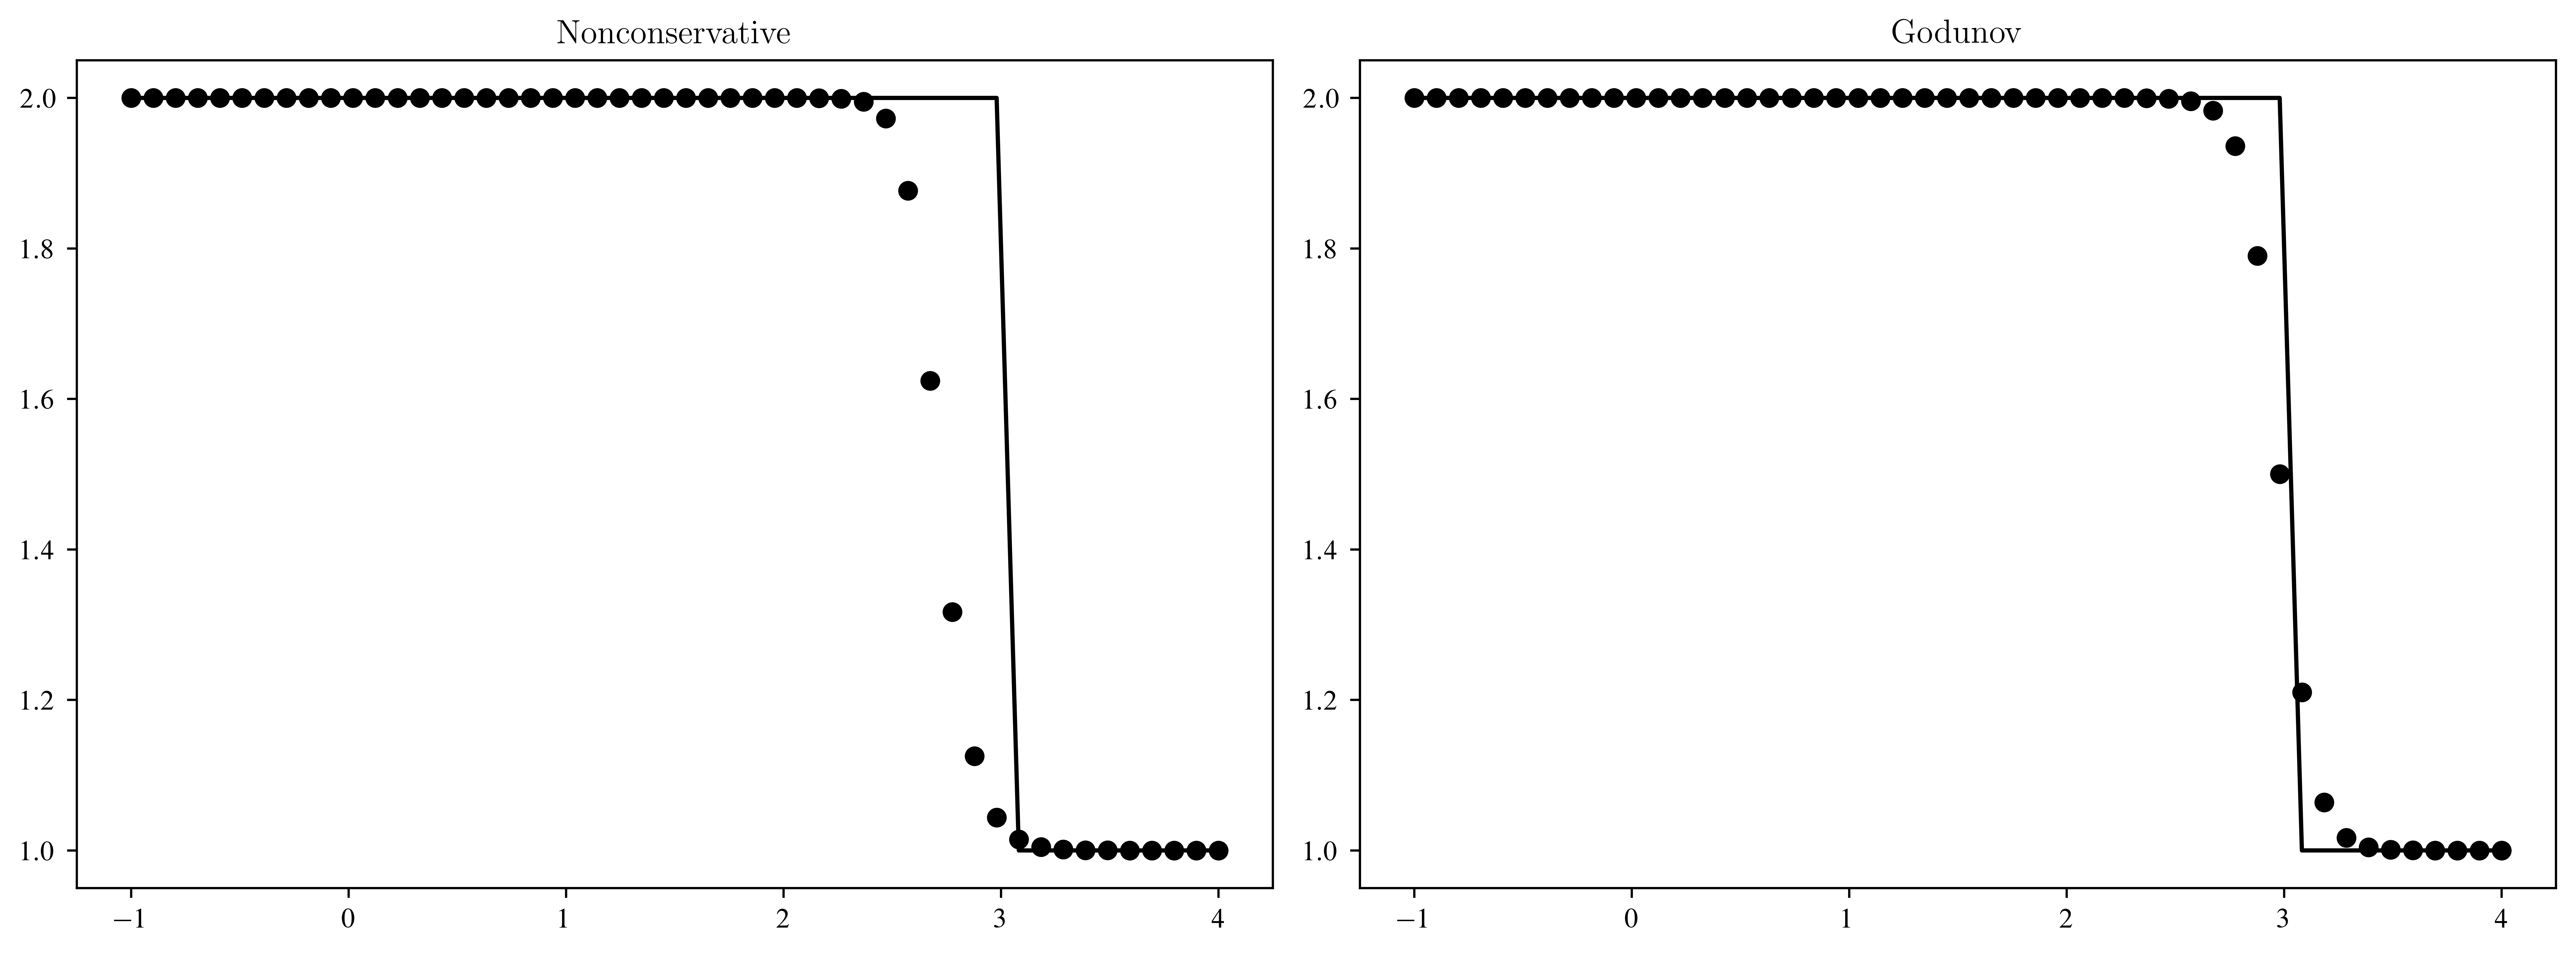

In [4]:
N = 50
x = numpy.linspace(-1, 4, N)
dx = x[1] - x[0]
u_ell = 2.0
u_r = 1.0
s = 0.5 * (u_r + u_ell)
dt = 0.5 * dx / s
t_vec = numpy.arange(0.0, 2.0 + dt, dt)

def true_solution(x, t, s):
    return (x < s * t) * u_ell * numpy.ones(x.shape) + \
           (x >= s * t) * u_r * numpy.ones(x.shape)

# Initial conditions
U_noncon = numpy.empty(shape=(t_vec.shape[0], x.shape[0] + 1))
U_noncon[0, 1:] = true_solution(x, 0.0, s)
U_con = numpy.empty(shape=(t_vec.shape[0], x.shape[0] + 1))
U_con[0, 1:] = true_solution(x, 0.0, s)

for (n, t) in enumerate(t_vec[1:]):
    # Set BC
    U_noncon[n, 0] = U_noncon[n, 1]
    U_con[n, 0] = U_con[n, 1]
    
    U_noncon[n + 1, 1:] = U_noncon[n, 1:] - dt / dx * U_noncon[n, 1:] * (U_noncon[n, 1:] - U_noncon[n, :-1])
    U_con[n + 1, 1:] = U_con[n, 1:] - dt / dx * 0.5 * ((U_con[n, 1:])**2 - (U_con[n, :-1])**2)

plot_index = -1
t_plot = t_vec[plot_index]
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(fig.get_figwidth() * 2)
axes[0].plot(x, U_noncon[plot_index, 1:], 'ko')
axes[0].plot(x, true_solution(x, t_plot, s), 'k-')
axes[0].set_title("Nonconservative")
axes[1].plot(x, U_con[plot_index, 1:], 'ko')
axes[1].plot(x, true_solution(x, t_plot, s), 'k-')
axes[1].set_title("Godunov")

plt.show()

## Lax-Wendroff Theorem

One question that may come to mind is whether a consistent approximation to the conservation law will converge to a weak solution of said conservation law.  Lax and Wendroff proved as much.

Consider a sequence of grids indexed by $j=1, 2, \ldots$, with mesh parameters $\Delta t^{(j)}, \Delta x^{(j)} \rightarrow 0$ as $j \rightarrow \infty$.  Let $Q^{(j)}(x, t)$ denote the numerical approximation computed with a consistent and conservative methods on the $j$th grid.

Define convergence from a grid function $Q^{(j)}(x,t)$ to $q(x,t)$ in the following sense:
1. Over every bounded set $\Omega = [a,b] \times [0,T]$, then
$$
    \int^T_0 \int^a_b |Q^{(j)}(x,t) - q(x,t)| dx dt \rightarrow 0 \text{   as } j\rightarrow \infty
$$
This is the 1-norm over $\Omega$ and therefore can instead write this as
$$
    ||Q^{(j)} - q||_{1,\Omega} \rightarrow 0 \text{   as } j \rightarrow \infty.
$$
1. We also assume that for each $T \quad \exists R > 0$ s.t.
$$
    \text{TV}(Q^{(j)}) < R \quad \forall 0 \leq t \leq T, \quad j=1,2,\ldots
$$
where TV denotes the total variation function.

**Lax-Wendroff Theorem:**    Suppose that $Q^{(j)}$ converges to a function $q$ as $j \rightarrow \infty$, in the sense described above.  Then $q(x,t)$ is a weak solution of the conservation law.

To prove this theorem we will show that the limit function $q(x,t)$ satisfies the weak form for all $\phi \in C^1_0$.,
$$
    \int^\infty_0 \int^\infty_{-\infty} [\phi_t q + \phi_x f(q)] dx dt = - \int^\infty_{-\infty} \phi(x, 0) q(x, 0) dx.
$$

Now define a grid version of $\phi$ so that we have $\Phi^{(j)}$ as an analogous gridded function.  Also define the relationship between subsequent grids by $\Phi^{(j)n}$ and similarly for $Q^{(j) n}_i$.  Now dropping the $j$ indexing but keeping the idea that $j \rightarrow \infty$ we move forward.

Take the original conservative method as
$$
    Q^{n+1}_i = Q^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1/2} - F^n_{i-1/2} )
$$
and multiply by the gridded version of $\phi$ to find
$$
    \Phi^n_i Q^{n+1}_i = \Phi^n_i Q^n_i - \frac{\Delta t}{\Delta x} \Phi^n_i (F^n_{i+1/2} - F^n_{i-1/2} )
$$
that should be true for all values of $i$ and $n$ on each grid $j$.  Summing these over all $i$ and $n$ leads to
$$
    \sum^\infty_{n=0} \sum^\infty_{i=-\infty} \Phi^n_i(Q^{n+1}_i - Q^n_i) = -\frac{\Delta t}{\Delta x} \sum^\infty_{n=0} \sum^\infty_{i=-\infty} \Phi^n_i (F^n_{i+1/2} - F^n_{i-1/2}).
$$

Summation by parts (similar to integration by parts) leads to
$$
    - \sum^\infty_{-\infty} \Phi^0_i Q^0_i - \sum^\infty_{n=1} \sum^\infty_{i=-\infty} (\Phi^n_i - \Phi^{n-1}_i) Q^n_i = \frac{\Delta t}{\Delta x} \sum^\infty_{n=0} \sum^\infty_{i=-\infty} (\Phi^n_{i+1} - \Phi^n_i) F^n_{i-1/2}.
$$
Since $\Phi$ is compactly supported we in fact have the following:
$$
    \Delta x \Delta t \left [  \sum^\infty_{n=1} \sum^\infty_{i=-\infty} \left( \frac{\Phi^n_i - \Phi^{n-1}_{i}}{\Delta t} \right )Q^n_i + \sum^\infty_{n=0} \sum^\infty_{i=-\infty} \left( \frac{\Phi^n_{i+1} - \Phi^{n}_{i}}{\Delta x} \right ) F^n_{i-1/2} \right ] = -\Delta x \sum^\infty_{i=-\infty} \Phi^0_i Q^0_i
$$

At this point we can see that many of these terms go to zero as $j \rightarrow 0$.  The remaining flux function however are a bit more complex and lead to the additional assumptions that we have already imposed.  We then have
$$
    F^n_{i-1/2} \equiv F^{(j)n}_{i-1/2} = \mathcal{F}(Q^{(j)n}_{i-1}, Q^{(j)n}_i)
$$
with
$$
    |F^{(j)n}_{i-1/2} - f(Q^{(j)n}_i) | \leq L | Q^{(j)n}_{i} -Q^{(j)n}_{i-1},
$$
a clear Lipschitz condition.

If 
$$
    |F^{(j)n}_{i-1/2} - f(Q^{(j)n}_i) | \rightarrow 0 \text{   as } j\rightarrow \infty
$$
for almost all $i$ then we can say
$$
    \Delta x \Delta t \sum^\infty_{n=0} \sum^\infty_{i=-\infty} \left( \frac{\Phi^n_{i+1} - \Phi^{n}_{i}}{\Delta x} \right ) F^n_{i-1/2} \rightarrow \int^\infty_{0} \int^\infty_{-\infty} \phi_x(x,t) f(q(x,t)) dx dt
$$

## Entropy Conditions Revisited

Recall that the Lax-Wendroff theorem states that we will find a weak solution to the conservation law but not that the solution will be an entropy satisfying one.  We will correct this with an entropy condition.

Going back to the entropy inequality that was introduced before we have
$$
    \eta(q)_t + \psi(q)_x \leq 0
$$
and in the weak sense
$$
    \int^\infty_0 \int^\infty_{-\infty} [ \phi_t \eta(q) + \phi_x \psi(q) ] dx dt + \int^\infty_{-\infty} \phi(x,0) \eta(q(x,0)) dx \geq 0
$$
where $\phi \in C^1_0$ and $\phi(x,t) \geq 0 ~\forall ~x, t$.

To show that the solution $Q^{(j)} \rightarrow q(x,t)$ obtained satisfies the entropy inequality we will turn to a discrete version of the entropy inequality
$$
    \eta(Q^{n+1}_i) \leq \eta(Q^n_i) - \frac{\Delta t}{\Delta x} (\Psi^n_{i+1/2} - \Psi^n_{i-1/2})
$$
and check to see if it holds (this is sufficient to prove the inequality holds).  Here
$$
    \Psi^n_{i-1/2} = \Psi(Q^n_{i-1}, Q^n_i)
$$
where we require that this numerical entropy flux function be consistent with $\psi$ in the same manner as we require $F^n_{i-1/2}$ to be.

Now we can mimic the proof of the Lax-Wendroff theorem by multiplying by $\Phi^n_i$ and summing over $i$ and $n$.

### Entropy Consistency of Godunov Methods

Godunov's method can be shown to always satisfy the entropy condition provided that the Riemann solution used satisfies the entropy condition at each cell interface.

For the first order case we have a reconstructed function $\widetilde{q}^n(x, t_n)$ that is exactly evolved to get $\widetilde{q}^{n+1}(x, t_{n+1})$ and then averaged onto the grid.  If $\widetilde{q}(x, t)$ then satisfies the entropy condition then we can show that the solution obtained will satisfy the discrete form of the equation.

Formalizing this idea we will integrating the entropy condition over $(x_{i-1/2}, x_{i+1/2}) \times (t_n, t_{n+1})$ leads us to
$$
    \int^{x_{i+1/2}}_{x_{i-1/2}} \eta(\widetilde{q}^n(x, t_{n+1}) dx \leq \int^{x_{i+1/2}}_{x_{i-1/2}} \eta(\widetilde{q}^n(x, t_n)) dx + \int^{t_{n+1}}_{t_n} \psi(\widetilde{q}^n(x_{i-1/2},t)) dt - \int^{t_{n+1}}_{t_n} \psi(\widetilde{q}^n(x_{i+1/2},t)) dt.
$$
The integrals on the right hand side of this inequality are all easy to evaluate as $\widetilde{q}^n$ is constant along these edges of the rectangle.  Simplifying this way and dividing by $x_{i+1/2} - x_{i-1/2} = \Delta x$ we have
$$
    \frac{1}{\Delta x} \int^{x_{i+1/2}}_{x_{i-1/2}} \eta(\widetilde{q}^n(x, t_{n+1}) dx \leq \eta(Q^n_i) - \frac{\Delta t}{\Delta x} [\psi(\widehat{Q}_{i+1/2}) - \psi(\widehat{Q}_{i-1/2})].
$$
If we now pick as our numerical entropy flux function
$$
    \Psi^n_{i-1/2} = \psi(\widehat{Q}_{i-1/2})
$$
then $\Psi^n_{i-1/2}$ is consistent with $\psi$ in the correct sense.

We are not done yet as we have yet to evaluate the left hand side of the inequality
$$
    \frac{1}{\Delta x} \int^{x_{i+1/2}}_{x_{i-1/2}} \eta(\widetilde{q}^n(x, t_{n+1})) dx.
$$
Since $\eta(q)$ is assumed to be convex (i.e. $\eta''(q) > 0$) then we can apply Jensen's inequality that states that the value of $\eta$ evaluated at the average value of $\widetilde{q}^n$ follows
$$
    \eta\left(\frac{1}{\Delta x} \int^{x_{i+1/2}}_{x_{i-1/2}} \widetilde{q}^n(x, t_{n+1}) dx\right) \leq \frac{1}{\Delta x} \int^{x_{i+1/2}}_{x_{i-1/2}} \eta(\widetilde{q}^n(x, t_{n+1})) dx.
$$
This of course leads to
$$
    \eta(Q^{n+1}_i) = \eta\left(\frac{1}{\Delta x} \int^{x_{i+1/2}}_{x_{i-1/2}} \widetilde{q}^n(x, t_{n+1}) dx\right) \leq \frac{1}{\Delta x} \int^{x_{i+1/2}}_{x_{i-1/2}} \eta(\widetilde{q}^n(x, t_{n+1}) dx \leq \eta(Q^n_i) - \frac{\Delta t}{\Delta x} [\psi(\widehat{Q}_{i+1/2}) - \psi(\widehat{Q}_{i-1/2})],
$$
which is exactly what we wanted to show.

This proof extends then to any Riemann solver that can compute entropy satisfying solutions.  For Godunov's method directly this means we only need to handle the case of a transonic rarefaction to satisfy this condition.  This proof also extends to nonlinear systems of equations.

## Nonlinear Stability

One other issue that is not addressed in the Lax-Wendroff Theorem is whether or not a method converges as it only speaks towards solutions that converges.  We now need to add some idea of stability.

Note that the Lax equivalence theorem no longer holds for nonlinear problems.  We can however use a previous convergence proof from earlier in the semester in the nonlinear case if the numerical method is contractive in some norm (recall we relied on this to prove convergence before).  This is particularly true for **monotone methods** that have the property
$$
    \frac{\partial Q^{n+1}_i}{\partial Q^n_j} \geq 0 \quad \forall j.
$$
This can be motivated in the case for vanishing viscosity solutions as this would be what we would expect to happen.  This unfortunately is not always true for higher-order accurate methods and many other methods of interest.

Instead we will turn to total-variation as tool that has proven to be successful at proving convergence of a large class of practical methods.  Unfortunately this has only been successful for scalar problems except for a small handful of cases and the more general problem of convergence for general systems of hyperbolic equations with arbitrary initial conditions remains elusive to this day.

### Notions of Convergence

First we need to define a grid function that is defined by discrete values $Q^n_i$ to the function $q(x,t)$ which we will do with the  piecewise-constant function
$$
    Q^{(\Delta t)}(x,t) = Q^n_i \quad \text{for } (x,t) \in [x_{i-1/2},x_{i+1/2}) \times [t_n, t_{n+1})
$$
indexed in this case by $\Delta t$ (or $\Delta x$ if you prefer).

The first issue we find is that the global error defined by
$$
    Q^{(\Delta t)} - q(x,t)
$$
is not well defined when $q(x,t)$ is expected to only be a weak solution of the conservation law and therefore non-unique.  Instead we will measure the distance from $Q^{(\Delta t)}$ to the set of *all* weak solutions defined as the set
$$
    \mathcal{W} = \{q: q(x,t) \text{ is a weak solution to the conservation law} \}.
$$

As mentioned previously the 1-norm is the most commonly used norm for conservation laws so we will therefore the 1-norm defined as
$$
    ||v||_{1,T} = \int^T_0 ||v(\cdot, t)||_1 dt = \int^T_0 \int^\infty_{-\infty} |v(x,t)| dx dt.
$$
The global error is then defined by
$$
    \text{dist}(Q^{(\Delta t)}, \mathcal{W}) = \inf_{w \in \mathcal{W}} ||Q^{(\Delta t)} - q(x,t)||_{1,T}.
$$

We can now make a general statement about the convergence we would like to prove:

> If $Q^{(\Delta t)}$ is generated by a numerical method in conservation form, consistent with the conservation law, and if the method is stable in some appropriate sense, then
$$
    \text{dist}(Q^{(\Delta t)}, \mathcal{W}) \rightarrow 0 \quad \text{as} \quad \Delta t \rightarrow 0.
$$

One important thing to note is that we are not guaranteed to converge to a particular weak solution.  Instead we could be closer to one solution for a given $\Delta t$ and another for a different one.  This of course practically speaking is not a concern as we only want to usually compute on a single given grid but it can be difficult when speaking about overall convergence rates.

In the end though we probably want to show that we converge to the entropy satisfying weak solution.  This can be done if the method satisfies a discrete form of the entropy condition like we showed for Godunov's method.

### Compactness

It is now useful to carefully define compactness in the sense we are going to find the most useful.

A **compact set** $\mathcal{K}$ in some normed space is one where any infinite sequence of elements $k_j \in \mathcal{K}$ where $\{\kappa_1, \kappa_2, \kappa_3, \ldots \}$ contains a subsequence that converges to some $\kappa \in \mathcal{K}$.

This definition implies that some infinite subsequence of elements $\{\kappa_{i_1}, \kappa_{i_2}, \kappa_{i_3}, \ldots \}$ also converges to $\kappa \in \mathcal{K}$ or
$$
    ||\kappa_{i_j} - \kappa|| \rightarrow 0 \quad \text{as } j\rightarrow\infty.
$$

#### Examples:  Compact Sets in $\mathbb R$

It bears examining for a bit a couple of important examples.  Let's first consider sets in $\mathbb R$ with the absolute value as the norm.

1. Is the set $[0, 1]$ a compact set? Consider for example the sequence defined by $\{0, 1, 0, 1, 0, 1, \ldots \}$.
1. Is the set $(0,1)$ a compact set?  Consider for example the sequence defined by $\{1, 10^{-1}, 10^{-2}, 10^{-3}, \ldots \}$.
1. Is an unbounded set such as $[0, \infty)$ compact?  Consider here the sequence $\{1, 2, 3, \ldots \}$.
1. In the $n$-dimensional $\mathbb R^n$ with any vector norm $||\cdot||$ is the closed ball
$$
    B_R = \{x \in \mathbb R^n : ||x|| \leq R\}
$$
a compact set?

### Function Spaces

Another concept we will need to use is the idea of a compact set in a normed **function space**.  The space that will consider is
$$
    L_{1,T} = \{v(x) : ||v||_1 < \infty \},
$$
which is infinite dimensional.  We can see this as we can easily define a set of basis functions
$$
    v_j(x) = \left \{ \begin{aligned}
        1 & & \text{if } j < x < j + 1 \\
        0 & & \text{otherwise}
    \end{aligned} \right .
$$
that are linearly independent and infinite.

#### Examples:  Compact Sets in $L_{1,T}$

As compact sets are highly non-trivial notion in infinite dimensional spaces we examine two cases here.

1. The sequence of functions $\{v_1, v_2, v_3, \ldots \}$ forming the aforementioned basis all lie in the closed and bounded unit ball
$$
    B_1 = \{ v \in L_1 : ||v||_1 \leq 1 \}.
$$
Is this a compact set?
1. Instead is a set of the form
$$
    \{v \in L_1 : ||v||_1 \leq R \quad \text{and} \quad \text{Supp}(v) \subset [-M, M] \}
$$
compact?  One set of functions that have this property is
$$
    v_j(x) = \left \{ \begin{aligned}
        \sin(j x) & & \text{if } |x| \leq 1 \\
        0 & & \text{if } |x| > 1
    \end{aligned} \right .
$$

### Total-Variation Stability

As we have seen compact sets in the function space $L_{1,T}$ may not be trivial to define or find.  Luckily we have already explored a concept that can lead to compact sets, the total-variation.  The set defined by
$$
    \{v \in L_1 : \text{TV}(v) \leq R \quad \text{and} \quad \text{Supp}(v) \subset [-M, M] \}
$$
is a compact set!

Since we have functions of $x$ and $t$ we will define total variation in terms of both leading to the definition
$$\begin{aligned}
    \text{TV}_T(q) = \limsup_{\epsilon \rightarrow 0} \frac{1}{\epsilon} \int^T_0 \int^\infty_{-\infty} | q(x + \epsilon,t) - q(x,t)| dx dt \\
    \quad \quad+ \limsup_{\epsilon \rightarrow 0} \frac{1}{\epsilon} \int^T_0 \int^\infty_{-\infty} | q(x,t+ \epsilon) - q(x,t)| dx dt.
\end{aligned}$$
It can then be shown that
$$
    \mathcal{K} = \{q \in L_{1,T} : \text{TV}_T(q) \leq R \quad \text{and} \quad \text{Supp}(q(\cdot, t)) \subset [-M, M] \quad \forall t \in [0, T] \}
$$
is a compact set in $L_{1,T}$.

If we reduce our grid functions to $Q^{(\Delta t)}(x,t)$ are piecewise constant (which they are), the above definition simplifies to
$$
    \text{TV}_T(Q^{(\Delta t)}) = \sum^{T / \Delta t}_{n=0} \sum^\infty_{j=-\infty} \left[\Delta t |Q^n_{i+1} - Q^n_i| + \Delta x |Q^{n+1}_i - Q^n_i| \right ]
$$
or in 1-dimension
$$
    \text{TV}_T(Q^{(\Delta t)}) = \sum^{T / \Delta t}_{n=0}  \left[\Delta t \text{ TV}(Q^n) + ||Q^{n+1} - Q^n||_1 \right]
$$

Finally we come to a definition defined by the above:

A numerical method is **total-variation stable** (or **TV-stable**) if all approximations $Q^{(\Delta t)}$ for $\Delta t < \Delta t_0$ lie in some fixed set of the form
$$
    \mathcal{K} = \{q \in L_{1,T} : \text{TV}_T(q) \leq R \quad \text{and} \quad \text{Supp}(q(\cdot, t)) \subset [-M, M] \quad \forall t \in [0, T] \},
$$
where $R$ and $M$ may depend on $q(x,0)$, the time $T$, and the flux function $f(q)$, but not $\Delta t$.

Not that the condition on the support of $q$ is always satisfied for any explicit method if $q(x,0)$ has compact support and $\Delta t / \Delta x$ is constant as $\Delta t \rightarrow 0$.

This definition is still quite complex but we can also simplify by noting the following theorem:

> Consider a conservative method with a Lipschitz-continuous numerical flux $F^n_{i-1/2}$ and that for each initial data $q(x,0) ~ \exists \Delta t_0, R > 0$ such that
$$
    \text{TV}(Q^n) \leq R \quad \forall n, \Delta t \quad \text{with } \Delta t < \Delta t_0, \quad n \Delta t \leq T
$$
then the method is TV-stable.

The proof of this is instructive but requires an additional lemma:

> If $Q^n$ is generated by a conservative method with a Lipschitz-continuous numerical flux function, then the bound
$$
    \text{TV}(Q^n) \leq R \quad \forall n, \Delta t \quad \text{with } \Delta t < \Delta t_0, \quad n \Delta t \leq T
$$
implies that there exists $\alpha > 0$ such that
$$
    ||Q^{n+1} - Q^n ||_1 \leq \alpha \Delta t \quad \forall n, \Delta t \quad \text{with } \Delta t < \Delta t_0, \quad n \Delta t \leq T.
$$

Proving this lemma first, recall that a method in conservation form should take a form where
$$
    Q^{n+1}_i - Q^n_i = \frac{\Delta t}{\Delta x} (F^n_{i+1/2} - F^n_{i-1/2})
$$
and therefore
$$
    ||Q^{n+1}_i - Q^n_i||_1 = \Delta t \sum^\infty_{j=-\infty} |F^n_{i+1/2} - F^n_{i-1/2}|.
$$
The flux at time $t_n, F^n_{i-1/2}$ depends on a finite number of values $Q_{i-p}, \ldots , Q_{i+r}$ so that the bound and compact support of each $Q^n$ leads to
$$
    |Q^n_i| \leq R / 2 \quad \forall i, n \quad \text{with } n \Delta t \leq T.
$$
This therefore defines a uniform bound on $Q^n_i$ and together with Lipschitz continuity of $f(q)$ leads to
$$
    |F^n_{i+1/2} - F^n_{i-1/2}| \leq K \max_{-p \leq j \leq r} |Q^n_{i+j} - Q^n_{i+j-1} |.
$$

It then follows that
$$
    |F^n_{i+1/2} - F^n_{i-1/2}| \leq K \sum^r_{j=-p} |Q^n_{i+j} - Q^n_{i+j-1} |
$$
and therefore
$$
    ||Q^{n+1} - Q^n||_1 \leq \Delta t K \sum^r_{j=-p} \sum^\infty_{i=-\infty} |Q^n_{i+j} - Q^n_{i+j-1} |.
$$
This latter sum is the definition of $\text{TV}(Q^n)$ and therefore
$$\begin{aligned}
    ||Q^{n+1} - Q^n||_1 &\leq \Delta t K \sum^r_{j=-p} \text{TV}(Q^n) \\
    &\leq \Delta t K (p + r+ 1) R.
\end{aligned}$$

Now that the lemma is proved we can easily prove the original theorem.

Using 
$$
    \text{TV}(Q^n) \leq R \quad \forall n, \Delta t \quad \text{with } \Delta t < \Delta t_0, \quad n \Delta t \leq T
$$
and
$$
    ||Q^{n+1} - Q^n ||_1 \leq \alpha \Delta t \quad \forall n, \Delta t \quad \text{with } \Delta t < \Delta t_0, \quad n \Delta t \leq T
$$
in
$$
    \text{TV}_T(Q^{(\Delta t)}) = \sum^{T / \Delta t}_{n=0}  \left[\Delta t \text{ TV}(Q^n) + ||Q^{n+1} - Q^n||_1 \right]
$$
we have
$$\begin{aligned}
    \text{TV}_T(Q^{(\Delta t)}) & \leq \sum^{T / \Delta t}_{n=0} [\Delta t R + \alpha \Delta t] \\
    &\leq \Delta t (R + \alpha) \frac{T}{\Delta t} = (R + \alpha) T,
\end{aligned}$$
which holds for all $\Delta t < \Delta t_0$ and therefore showing that $\text{TV}_T(Q^{(\Delta t)}$ is uniformaly bounded as $\Delta t \rightarrow 0$.  This then implies that $Q^{(\Delta t)}$ are in the set
$$
    \mathcal{K} = \{q \in L_{1,T} : \text{TV}_T(q) \leq R \quad \text{and} \quad \text{Supp}(q(\cdot, t)) \subset [-M, M] \quad \forall t \in [0, T] \}
$$
if the speed of propagation is finite (of course we have this) and the method is therefore TV-stable.

Now that we have defined a compact set using TV-stability we can finally define our convergence theorem.

> Suppose $Q^{(\Delta t)}$ is generated by a numerical method in conservation form with a Lipschitz continuous numerical flux, consistent with some scalar conservation law.  If the method is TV-stable then the method is convergent in the sense
$$
    \text{dist}(Q^{(\Delta t)}, \mathcal{W}) \rightarrow 0 \text{ as } \Delta t \rightarrow 0
$$

We will now prove this theorem by contradiction.  Assume that
$$
    \text{dist}(Q^{(\Delta t_j)}, \mathcal{W}) > \epsilon \quad \forall j.
$$
Since $Q^{(\Delta t_j)} \in \mathcal{K}$, a compact set for all $j$, then this sequence must have a convergent subsequence converging to some element $\kappa \in \mathcal{K}$.  This then implies that
$$
    || Q^{(\Delta t_j)} - v ||_{1,T} < \epsilon \quad \forall j \text{ sufficiently large.}
$$

We also know via the Lax-Wendroff theorem that the limit $\kappa$ must be a weak solution of the conservation law, i.e. $\kappa \in \mathcal{W}$.  This then leads to a contradiction.